In [1]:
import os
import scipy
import hyperspy.api as hs

import numpy as np
import numpy.ma as ma
import h5py

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.colors import to_rgb, LinearSegmentedColormap
import matplotlib.patches as patches

import pandas as pd

import sklearn as skl
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

import skimage as ski
from skimage.segmentation import random_walker
from skimage.feature import peak_local_max
from skimage import exposure
from skimage import measure
from skimage import morphology as mph
from skimage import restoration
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

from skimage.transform import hough_line, hough_line_peaks, rescale
from skimage.color import label2rgb

import skimage.io as io

import hdbscan

import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist

In [2]:
#Josh's Calibration functions
def h5printR(item, leading = ''):
    for key in item:
        if isinstance(item[key], h5py.Dataset):
            print(leading + key + ': ' + str(item[key].shape))
        else:
            print(leading + key)
            h5printR(item[key], leading + '  ')

# Print structure of a `.h5` file            
def h5print(filename):
    with h5py.File(filename, 'r') as h:
        print(filename)
        h5printR(h, '  ')

In [28]:
def compute_elbow_bic(data, max_clusters=10, use_gmm=False):
    """
    Compute the elbow method and BIC values for KMeans or GMM with varying number of clusters.

    Parameters
    ----------
    data : array-like or pd.DataFrame, shape (n_samples, n_features)
        Input data to be clustered. This represents the observations for clustering.
    max_clusters : int, optional, default: 10
        Maximum number of clusters to evaluate. Determines the range of cluster numbers to be considered.
    use_gmm : bool, optional, default: False
        If True, use Gaussian Mixture Model for BIC computation.
        If False, use log-likelihood and KMeans model for BIC computation. This choice reflects different modeling assumptions.

    Returns
    -------
    results : dict
        A dictionary containing:
        - 'ks': range of cluster numbers evaluated,
        - 'distortions': inertia or within-cluster sum-of-squares for each k,
        - 'bics': BIC values for each number of clusters using the chosen model. Helps in model selection by balancing fit and complexity.

    ...

    """
    
    ks = range(1, max_clusters + 1)
    distortions = []
    bics = []
    
    X_scaled = StandardScaler().fit_transform(data)

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
        distortions.append(kmeans.inertia_)

        if use_gmm:
            # BIC with Gaussian Mixture Model
            gmm = GaussianMixture(n_components=k, random_state=42).fit(X_scaled)
            bic = gmm.bic(X_scaled)
        else:
            # BIC with log-likelihood and KMeans model
            log_likelihood = np.sum(np.log(np.min(cdist(X_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)))
            n_features = data.shape[1]
            n_samples = data.shape[0]
            bic = -2 * log_likelihood + np.log(n_samples) * n_features * k
        
        bics.append(bic)

    results = {
        'ks': ks,
        'distortions': distortions,
        'bics': bics
    }

    return results

In [4]:
# Keep the other functions (plot_elbow, plot_bic, and find_elbow) unchanged

def plot_elbow(ks, distortions):
    """
    Plot the elbow method results.

    This function visualizes the elbow method by plotting the distortion (within-cluster sum-of-squares) for different values of k.
    It highlights the optimal value of k (the "elbow" point), which represents a balance between precision and computational cost.

    Parameters
    ----------
    ks : list
        Range of cluster numbers evaluated. Reflects the granularity of the clustering.
    distortions : list
        Distortion values for each number of clusters using the KMeans model. Captures the compactness of the clusters.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(ks, distortions, marker='o')

    # Find the optimal number of clusters using the elbow method
    optimal_k = find_elbow(distortions)
    plt.plot(optimal_k, distortions[optimal_k - 1], marker='o', markersize=10,
             label=f'Optimal k: {optimal_k}', color='r')

    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion')
    plt.title('Elbow method')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_bic(ks, bics):
    """
    Plot the BIC (Bayesian Information Criterion) method results.

    This function visualizes the BIC method by plotting the BIC values for different numbers of clusters (k).
    It emphasizes the optimal value of k that minimizes BIC, thus striking a balance between model fit and complexity.

    Parameters
    ----------
    ks : list
        Range of cluster numbers evaluated. Reflects the trade-off between flexibility and overfitting.
    bics : list
        BIC values for each number of clusters using the GaussianMixture model. Encapsulates model likelihood and penalizes complexity.
    """
    
    plt.figure(figsize=(8, 6))
    plt.plot(ks, bics, marker='o')

    # Find the optimal number of clusters using the lowest BIC value
    optimal_k = np.argmin(bics) + 1
    plt.plot(optimal_k, bics[optimal_k - 1], marker='o', markersize=10,
             label=f'Optimal k: {optimal_k}', color='r')

    plt.xlabel('Number of clusters (k)')
    plt.ylabel('BIC')
    plt.title('BIC method')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
def find_elbow(distortions):
    """
    Finds the elbow point in a curve using the maximum distance method.

    This function determines the optimal number of clusters (k) in a clustering algorithm, where the "elbow" point represents
    a balance between minimizing distortion and minimizing the number of clusters. It's an essential aspect of understanding 
    the inherent structure of the data.

    Parameters
    ----------
    distortions : list
        A list of distortion values calculated for different numbers of clusters. Represents the within-cluster sum-of-squares.

    Returns
    -------
    int
        The optimal number of clusters corresponding to the elbow point. This value captures the inherent granularity of the data.
    """
    
    # Coordinates of the first point in the curve (cluster number, distortion)
    x1, y1 = 1, distortions[0]
    # Coordinates of the last point in the curve (cluster number, distortion)
    x2, y2 = len(distortions), distortions[-1]

    distances = []
    for i, d in enumerate(distortions):
        # Current point's coordinates (cluster number, distortion)
        x0 = i + 1
        y0 = d
        
        # Calculate the distance between the current point and the line connecting the first and last points
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = ((y2 - y1)**2 + (x2 - x1)**2)**0.5
        distances.append(numerator / denominator)

    return distances.index(max(distances)) + 1



def plot_elbow_bic_seaborn(ks, distortions, bics, optimal_k, title='Elbow and BIC Plot'):
    """
    Plot the elbow and BIC curve using Seaborn library.

    This function creates a comparative visualization of the elbow and BIC methods, giving insights into the structure of the data and
    the modeling choices. The plot assists in understanding the trade-off between model fit and complexity, providing a path towards
    theoretical clarity.

    Parameters
    ----------
    ks : list
        The range of cluster numbers evaluated. Represents the potential resolutions of clustering.
    distortions : list
        The distortions (inertia) for each number of clusters. Reflects the compactness of the clusters.
    bics : list
        The BIC values for each number of clusters. Integrates the likelihood and penalizes for complexity.
    optimal_k : int
        The optimal number of clusters. Represents the point of balance in the trade-off between precision and computational cost.
    title : str, optional, default: 'Elbow and BIC Plot'
        Title of the plot. Allows for context-specific naming.

    """
    
    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'Number of Clusters': ks,
        'Distortion': distortions,
        'BIC': bics
    })

    # Set the Seaborn theme and color palette
    sns.set_theme()
    sns.set_palette("pastel")

    # Create the figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the elbow curve
    sns.lineplot(data=results_df, x='Number of Clusters', y='Distortion', ax=ax1, label='Distortion')
    ax1.set_ylabel('Distortion')

    # Create a secondary axis for BIC
    ax2 = ax1.twinx()
    sns.lineplot(data=results_df, x='Number of Clusters', y='BIC', ax=ax2, color='g', label='BIC')
    ax2.set_ylabel('BIC')

    # Highlight and label the optimal number of clusters
    ax1.axvline(optimal_k, color='r', linestyle='--')
    ax1.text(optimal_k, distortions[optimal_k - 1], f'Optimal k = {optimal_k}', fontsize=12, color='r')

    # Set the title and legend
    plt.title(title)
    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    plt.show()

In [6]:
#Faisals, added labled othe energy lines besides Ka
def add_xrl_labels(data_array, amplitude_thresh, ax, elements_list, colors_list, scale, offset):
   
    ele_dic = hs.material.elements.as_dictionary()  # call element dictionary from hyperspy library
    ofs = offset/scale
   
    for e_idx in range(0, len(elements_list)):
        # find peak position of element
        peak_ka = round((ele_dic[elements_list[e_idx]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)']/scale)-ofs)

        # if element peak exceeds upper or lower threshold
        if data_array[peak_ka] > amplitude_thresh*data_array.max() or data_array[peak_ka] < amplitude_thresh*data_array.min():
            # draw vline of Ka peak
            ax.vlines(x = peak_ka, ymin = 0, ymax = data_array[peak_ka], color = e_colors[e_idx])
           
            # draw vline of Kb peak
            if 'Kb' in ele_dic[elements_list[e_idx]]['Atomic_properties']['Xray_lines']:                 
                peak_kb = round((ele_dic[elements_list[e_idx]]['Atomic_properties']['Xray_lines']['Kb']['energy (keV)']/scale)-ofs)
                ax.vlines(x = peak_kb, ymin = 0, ymax = data_array[peak_kb], color = e_colors[e_idx])
            # draw vline of La peak        
            if 'La' in ele_dic[elements_list[e_idx]]['Atomic_properties']['Xray_lines']:                  
                peak_la = round((ele_dic[elements_list[e_idx]]['Atomic_properties']['Xray_lines']['La']['energy (keV)']/scale)-ofs)
                ax.vlines(x = peak_la, ymin = 0, ymax = data_array[peak_la], color = e_colors[e_idx])
            # draw vline of Ll peak        
            if 'Ll' in ele_dic[elements_list[e_idx]]['Atomic_properties']['Xray_lines']:                  
                peak_ll = round((ele_dic[elements_list[e_idx]]['Atomic_properties']['Xray_lines']['Ll']['energy (keV)']/scale)-ofs)
                ax.vlines(x = peak_ll, ymin = 0, ymax = data_array[peak_ll], color = e_colors[e_idx])
            # draw vline of Ln peak        
            if 'Ln' in ele_dic[elements_list[e_idx]]['Atomic_properties']['Xray_lines']:                  
                peak_ln = round((ele_dic[elements_list[e_idx]]['Atomic_properties']['Xray_lines']['Ln']['energy (keV)']/scale)-ofs)
                ax.vlines(x = peak_ln, ymin = 0, ymax = data_array[peak_ln], color = e_colors[e_idx])
            
            # place peak name and bounding box for positive peaks
            #Ka peaks
            if data_array[peak_ka] > 0:
                ax.text(x = peak_ka, y = data_array[peak_ka]+(0.05*data_array.max()), s = elements[e_idx], ha = 'center',
                        color = 'black')
                rect_height = (data_array.max() - data_array.min())*0.04
                e_rect = patches.Rectangle(xy = (peak_ka-30, data_array[peak_ka]+(0.05*data_array.max())),
                                           color = e_colors[e_idx], width = 60, height = rect_height+(0.5*rect_height))
                ax.add_patch(e_rect)
                
            if data_array[peak_ka] < 0:
                ax.text(x = peak_ka, y = data_array[peak_ka]+(0.05*data_array.max()), s = elements[e_idx], ha = 'center',
                        color = 'black')
                rect_height = (data_array.max() - data_array.min())*0.04
                e_rect = patches.Rectangle(xy = (peak_ka-30, data_array[peak_ka]+(0.05*data_array.max())),
                                           color = e_colors[e_idx], width = 60, height = rect_height+(0.5*rect_height))
                ax.add_patch(e_rect)
            
            

In [7]:
def poisson_noise_norm(signal):
    """normalises hyperspy style signal for poissonian noise. based on [Keenan2004]_.
    
    Parameters
    ----------'
    signal - a hyperspy data stack
    
    Returns
    -------
    normalised Signal in a vector format
        The decomposition loadings, as a Signal with same dimension as the original navigation dimensions.
    data_factor_signals : tuple of Signals
    
    """
    # retreive original data shape
    y, x, e = signal.data.shape
    
    print('inital mean=', signal.data.mean(),' inital max =', signal.data.max(),' inital min=', signal.data.min())
    with signal.unfolded(): 
            # The rest of the code assumes that the first data axis
            # is the navigation axis. We transpose the data if that
            # is not the case
            #navigation_shapes = np.asarray(signal.axes_manager.navigation_shape).squeeze() # array with x & y size
            #signal_shape = signal.axes_manager.signal_shape # value equal to number of energy channels
            
            if signal.axes_manager[0].index_in_array == 0:
                
                dc = signal.data.copy()
            else:
                dc = signal.data.T.copy()

             
            # make sure dc is correct data type for scaling
            dc = dc.astype('float64')
            
            aG = dc[:, :].sum(1).squeeze()
            bH = dc[:, :].sum(0).squeeze()
            #print(aG,bH)
            root_aG = np.sqrt(aG)[:, np.newaxis]
            root_bH = np.sqrt(bH)[np.newaxis, :]

            # We ignore numpy's warning when the result of an
            # operation produces nans - instead we set 0/0 = 0
            # Faisal: this is the key line of code that may have been causing problems on Hyperspy
            with np.errstate(divide="ignore", invalid="ignore"):
                # this is quation 8 of (Keenan & Kotula, 2004)
                dc[:, :] /= root_aG * root_bH
                dc[:, :] = np.nan_to_num(dc[:, :]) 
            
            
    print(dc.shape)
    print('scaled mean=',dc.mean(),' scaled max =',dc.max(),' scaled min=',dc.min())
            
    # convert dc array shape ((y*x), energy_channels) into d_norm (y, x, energy_channels)
    d_norm = dc.reshape(y, x, e)
            
    # convert d_norm numpy array into hyperspy EDSSEMSpectrum
    s_norm = hs.signals.EDSSEMSpectrum(d_norm)
    # copy metadata and axes_manager from original signal
    s_norm.metadata = signal.metadata
    s_norm.axes_manager = signal.axes_manager

    return s_norm, d_norm, dc   # return the hyperspy object s_norm, numpy array d_norm (y,x,energy) 
                                # and vectorised numpy array dc (y*x,energy)

In [8]:
def flatten_masked_array(im, mask):
    """Flatten an image array containing NaN values, or excluding False values from mask.
    
    Parameters
    ----------    
    im - an np array that requires masking (shape = (y, x, ...))
    mask - a binary boolean array (shape = (y, x)), True = data to be included in vect
                      False = NaN values excluded from vect
    
    Returns:
    --------
    vect - a flattened array from im, excluding NaN values (shape = ((y*x)-(number of NaN)), ...)
    """
    
    # for 2D images
    if len(im.shape)==2:
        vect = np.empty([])
        vect = np.vstack(im[mask==1])
    # for EDS spectral images
    elif len(im.shape)==3:
        vect = np.empty([])
        vect = np.vstack(im[mask==1, :])
    
    return vect

In [9]:
def reconstruct_masked_image(arr, mask, im_shape):
    """Reconstruct an image from a flattened array to contain masked NaN values.

    Parameters
    ----------
    arr - a flattened array, excluding NaN values from mask (shape = ((y*x)-(number of NaN)), ...)
    mask - a binary boolean array (shape = (y, x)), True = data belonging to arr, False = NaN values excluded from arr
    im_shape - tuple of desired image shape (e.g. (y, x, e))

    Returns:
    --------
    im - an image array (shape = (y, x, ...)), containing NaN values where (mask == False)
    """

    # for 2D images
    if len(im_shape)==2:
        # find desired image shape
        y_pix = im_shape[0]
        x_pix = im_shape[1]

        # create empty NaN array
        im = np.zeros((y_pix, x_pix))
        im[:] = np.nan

        # replace True values on mask array with the data from the flattened array
        index = 0
        for i in range(0, y_pix):
            for j in range(0, x_pix):
                if mask[i,j]==1:
                    im[i,j] = arr[index]
                    index+=1

    # for EDS spectral images
    elif len(im_shape)==3:
        # find desired image shape
        y_pix = im_shape[0]
        x_pix = im_shape[1]
        e_len = im_shape[2]

        # create empty NaN array
        im = np.zeros((y_pix, x_pix, e_len))
        im[:] = np.nan

        # replace True values on mask array with the data from the flattened array
        index = 0
        for i in range(0, y_pix):
            for j in range(0, x_pix):
                if mask[i,j]==1:
                    im[i,j,:] = arr[index]
                    index+=1

    return im

In [10]:
def poisson_scale_mask(data):
    """normalises numpy array signal for poissonian noise. based on [Keenan2004]_.
    
    Parameters
    ----------'
    data - a numpy array
    
    Returns
    -------
    normalised Signal in a vector format
        The decomposition loadings, as a Signal with same dimension as the original navigation dimensions.
    data_factor_signals : tuple of Signals
    
    """
    # retreive original data shape
    n, e = data.shape
    
    print('inital mean=', data.mean(),' inital max =', data.max(),' inital min=', data.min())

    dc = np.copy(data)
    
    # make sure dc is correct data type for scaling
    dc = dc.astype('float64')

    aG = dc[:, :].sum(1)
    bH = dc[:, :].sum(0)
    #print(aG,bH)
    root_aG = np.sqrt(aG)[:, np.newaxis]
    root_bH = np.sqrt(bH)[np.newaxis, :]

    # We ignore numpy's warning when the result of an
    # operation produces nans - instead we set 0/0 = 0
    with np.errstate(divide="ignore", invalid="ignore"):
        # this is quation 8 of (Keenan & Kotula, 2004)
        dc[:, :] /= root_aG * root_bH
        dc[:, :] = np.nan_to_num(dc[:, :]) 

            
    print(dc.shape)
    print('scaled mean=',dc.mean(),' scaled max =',dc.max(),' scaled min=',dc.min())

    return dc   # return the hyperspy object s_norm, numpy array d_norm (y,x,energy) 
                                # and vectorised numpy array dc (y*x,energy)

In [11]:
def plt_phasemap(labelled_im, bse_im = None, scale = 1, mpl_cmap = None, legend_labels = None, phasemap_title = ''):
    """Plot a phase map with scale
    
    """
    # create figure to the correct size for document
    plt.figure(figsize=(7.51181*2,5.51181*2))
    
    if type(bse_im)==np.ndarray:
        # plot the labels map as pcolormesh to get best quality image
        plt.imshow(bse_im, cmap='gray')
        im = plt.pcolormesh(labelled_im, cmap = mpl_cmap, alpha = 1)
    
    else:
        im = plt.imshow(labelled_im, cmap = mpl_cmap)

    # add additional plot parameters: title, no x/y ticks, colorbar
    plt.title(phasemap_title)
    plt.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
                    labelbottom=False,labelleft=False)
    plt.colorbar()

#     # create starting and end point coordinates for 100micron scalebar
#     y_strt = labelled_im.shape[0]-(labelled_im.shape[0]//20)
#     x_end = labelled_im.shape[1]-(labelled_im.shape[1]//20)
#     x_strt = int(x_end-10000/scale)
#     # plot and annotate scalebar
#     plt.hlines(y = (y_strt, y_strt+1, y_strt+2), xmin=x_strt ,xmax=x_end, colors='black')
#     plt.text(s='10\u03BCm', x=((x_end-x_strt)//2)+x_strt, y=y_strt-10, ha='center', fontsize=16, color='black')

In [12]:
def to_spx(spec, f_name = 'spectral_data'):
    
    '''
    Write a text file with format [f_name].spx, encoded as .spx requires, with name [f_name], 
    containing spectral data [data] from numpy array.
    
    Parameters
    ----------
    spec - 1D hyperspy object, containing spectral data (number of counts at each position)
    f_name - string object containing desired file name
    
    Dependencies
    ------------
    numpy[.array2string]
    hyperspy [.load; .data; .axes_manager]
    
    '''
    
    import numpy as np
    import hyperspy.api as hs
    
    data = spec.data 
    
    PrimaryEnergy = 20
    
    ElevationAngle = 70
    TiltAngle = 0
    
    ChannelCount = data.shape[0]
    Offset = spec.axes_manager[0].offset
    Scale = spec.axes_manager[0].scale

    # header string for .spx encoding
    spx_header = f'''<?xml version="1.0" encoding="WINDOWS-1252" standalone="yes"?>
        <TRTSpectrum>
          <RTHeader/>
          <ClassInstance Type="TRTSpectrum" Name="spec">
            <TRTHeaderedClass>
              <ClassInstance Type="TRTDetectorHeader">
                <TRTKnownHeader>
                  <Type>RTDetector</Type>
                  <Version>5</Version>
                  <Size>9936</Size>
                </TRTKnownHeader>
                <Technology>SDDpr</Technology>
                <Serial>13613</Serial>
                <Type>XFlash 6|60</Type>
                <DetectorThickness>4.5E-1</DetectorThickness>
                <SiDeadLayerThickness>2.9E-2</SiDeadLayerThickness>
                <DetLayers>eJyzcUkt8UmsTC0qtrMB0wYKjiX5ubZKhsZKCiEZmcnZeanFxbZKpq66xkr6UDWGUDXmKEos9ExddY3gioygikxRFJkhm2MMVWKGW4kJVIkFqhK4VfoI9wMAqUU9Ow==</DetLayers>
                <WindowType>slew AP3.3</WindowType>
                <WindowLayers>
                  <Layer0 Atom="5" Thickness="1.3E-2"/>
                  <Layer1 Atom="6" Thickness="1.45E-1"/>
                  <Layer2 Atom="7" Thickness="4.5E-2"/>
                  <Layer3 Atom="8" Thickness="8.5E-2"/>
                  <Layer4 Atom="13" Thickness="3.5E-2"/>
                  <Layer5 Atom="14" Thickness="3.8E2" RelativeArea="2.3E-1"/>
                </WindowLayers>
                <CorrectionType>3</CorrectionType>
                <ResponseFunctionCount>21</ResponseFunctionCount>
                <SampleCount>5</SampleCount>
                <SampleOffset>-3</SampleOffset>
                <PulsePairResTimeCount>8</PulsePairResTimeCount>
                <PileUpMinEnergy>4E-1</PileUpMinEnergy>
                <PileUpWithBG>1</PileUpWithBG>
                <TailFactor>1</TailFactor>
                <ShelfFactor>1</ShelfFactor>
                <ShiftFactor>4.09E-1</ShiftFactor>
                <ShiftFactor2>-8.9E-1</ShiftFactor2>
                <ShiftData>0.07,0.0058,0.183,0.0078,0.277,0.0058,0.555,0,1.1,0,3.293,0.0064,5.89,0,0,0,0,0,</ShiftData>
                <PPRTData>0.95,2.891959,1.05,2.195911,1.55,1.700256,1.75,1.604574,3.75,1.155987,4.55,0.980248,5.95,1.003,8.05,1.004377,</PPRTData>
                <ResponseFunction>0,0.01,0.000801,0.01,0.00298,0.01,0.008902,0.01,0.025,0.010046,0.041098,0.013475,0.04702,0.017302,0.049199,0.019237,0.05,0.02,</ResponseFunction>
                <ResponseFunction>0,0.03,0.00444,0.03,0.01651,0.03,0.049318,0.03,0.1385,0.03023,0.227682,0.047375,0.26049,0.06651,0.27256,0.076185,0.277,0.08,</ResponseFunction>
                <ResponseFunction>0,0.03,0.006283,0.03,0.023364,0.03,0.069793,0.03,0.196,0.030228,0.322207,0.047377,0.368636,0.066512,0.385717,0.076186,0.392,0.08,</ResponseFunction>
                <ResponseFunction>0,0,0.008415,0,0.031291,0,0.093473,0,0.2625,0,0.431527,0.000035,0.493709,0.000073,0.516585,0.000092,0.525,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.010836,0,0.040291,0,0.120357,0,0.338,0,0.555643,0.000035,0.635709,0.000073,0.665164,0.000092,0.676,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.016687,0,0.062045,0,0.185343,0,0.5205,0,0.855657,0.000035,0.978955,0.000073,1.024313,0.000092,1.041,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.020101,0,0.07474,0,0.223266,0,0.627,0,1.030734,0.000035,1.17926,0.000073,1.233899,0.000092,1.254,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.023836,0,0.088627,0,0.26475,0,0.7435,0,1.22225,0.000035,1.398373,0.000073,1.463164,0.000092,1.487,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.027891,0,0.103707,0,0.309795,0,0.87,0,1.430205,0.000035,1.636293,0.000073,1.712109,0.000092,1.74,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.030776,0,0.114435,0,0.341842,0,0.96,0,1.578158,0.000035,1.805565,0.000073,1.889224,0.000092,1.92,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.032283,0,0.120037,0,0.358578,0,1.007,0,1.655422,0.000035,1.893963,0.000073,1.981717,0.000092,2.014,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.036996,0,0.13756,0,0.410923,0,1.154,0,1.897077,0.000035,2.17044,0.000073,2.271004,0.000092,2.308,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.05918,0,0.220049,0,0.657334,0,1.846,0,3.034665,0.000035,3.471952,0.000073,3.63282,0.000092,3.692,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.079378,0,0.295146,0,0.881668,0,2.476,0,4.070332,0.000035,4.656854,0.000073,4.872623,0.000092,4.952,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.119867,0,0.445699,0,1.331404,0,3.739,0,6.146595,0.000035,7.0323,0.000073,7.358133,0.000092,7.478,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.148303,0,0.551433,0,1.647253,0,4.626,0,7.604747,0.000035,8.700567,0.000073,9.103698,0.000092,9.252,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.176322,0,0.655616,0,1.958472,0,5.5,0,9.041529,0.000035,10.344384,0.000073,10.823678,0.000092,11,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.208381,0,0.774819,0,2.314557,0,6.5,0,10.685443,0.000035,12.225181,0.000073,12.791619,0.000092,13,0.0001,</ResponseFunction>
                <ResponseFunction>0,0,0.24044,0,0.894022,0,2.670643,0,7.5,0,12.329357,0,14.105978,0,14.759561,0,15,0,</ResponseFunction>
                <ResponseFunction>0,0,0.320586,0,1.192029,0,3.560857,0,10,0,16.439142,0,18.80797,0,19.679415,0,20,0,</ResponseFunction>
                <ResponseFunction>0,0,1.60293,0,5.960146,0,17.804287,0,50,0,82.195709,0,94.039856,0,98.397072,0,100,0,</ResponseFunction>
              </ClassInstance>
              <ClassInstance Type="TRTESMAHeader">
                <TRTKnownHeader>
                  <Type>RTESMA</Type>
                  <Size>690</Size>
                </TRTKnownHeader>
                <PrimaryEnergy>{PrimaryEnergy}</PrimaryEnergy>
                <ReferenceFactor>-1</ReferenceFactor>
                <ReferenceStdDev>-1</ReferenceStdDev>
                <BaseRefStdDev>2.000100008E-3</BaseRefStdDev>
                <ElevationAngle>{ElevationAngle}</ElevationAngle>
                <TiltAngle>{TiltAngle}</TiltAngle>
                <CoatCorrection/>
                <Magnification>8E3</Magnification>
                <WorkingDistance>2.289617E1</WorkingDistance>
              </ClassInstance>
              <ClassInstance Type="TRTSpectrumHardwareHeader">
                <TRTKnownHeader>
                  <Type>RTHardware</Type>
                  <Size>183</Size>
                </TRTKnownHeader>
                <RealTime>31</RealTime>
                <LifeTime>13</LifeTime>
                <DeadTime>5.8E1</DeadTime>
                <ZeroPeakPosition>47</ZeroPeakPosition>
                <ZeroPeakFrequency>1000</ZeroPeakFrequency>
                <PulseDensity>786692</PulseDensity>
                <Amplification>2E4</Amplification>
                <ShapingTime>275000</ShapingTime>
                <DetectorTemperature>0</DetectorTemperature>
                <SPVType>SPV3</SPVType>
                <SPVRevision>XSPVIII R1.0.12 BNA</SPVRevision>
              </ClassInstance>
            </TRTHeaderedClass>
            <ClassInstance Type="TRTSpectrumHeader">
              <Size>82</Size>
              <Date>6.12.2018</Date>
              <Time>10:51:32</Time>
              <ChannelCount>{ChannelCount}</ChannelCount>
              <CalibAbs>{Offset}</CalibAbs>
              <CalibLin>{Scale}</CalibLin>
              <SigmaAbs>8.585985035E-4</SigmaAbs>
              <SigmaLin>3.959516845E-4</SigmaLin>
            </ClassInstance>
            <Channels>'''

    # footer string for .spx encoding
    spx_footer =  ''' </Channels>
        <ClassInstance Type="TRTBaseList"/>
        <ChildClassInstances>
          <ClassInstance Type="TRTSpectrumChartConfigurationData">
            <TRTChartConfigurationData>
              <XMin>6.45E1</XMin>
              <XMax>2.0485E3</XMax>
              <YMin>0</YMin>
              <YMax>3.277669052E3</YMax>
              <YMin2>0</YMin2>
              <YMax2>3.277669052</YMax2>
              <XAxisLog>0</XAxisLog>
              <YAxisLog>0</YAxisLog>
              <YAxisSqrt>0</YAxisSqrt>
              <LegendeVisible>0</LegendeVisible>
              <GridMode>Short</GridMode>
              <GridStyle>Lines</GridStyle>
              <GridColor>236,233,225</GridColor>
              <GridTransparency>0</GridTransparency>
              <MinXTicks>5</MinXTicks>
              <MinYTicks>5</MinYTicks>
              <SeriesScaling>0</SeriesScaling>
              <AxisFont>
                <Name>Calibri</Name>
                <Size>12</Size>
                <Color>0,0,0</Color>
              </AxisFont>
              <LegendeFont>
                <Name>Calibri</Name>
                <Size>12</Size>
                <Color>0,0,0</Color>
              </LegendeFont>
              <RightAxis>0</RightAxis>
              <SeriesProperties>
                <ClassInstance Type="TRTChartSeriesConfigurationData">
                  <Name>1</Name>
                  <Description>1</Description>
                  <Visible>1</Visible>
                  <Selected>1</Selected>
                  <LineColor>133,158,72</LineColor>
                  <FillColor>133,158,72</FillColor>
                  <Filled>1</Filled>
                  <LineStyle>Solid</LineStyle>
                  <LineWidth>1</LineWidth>
                  <Mark>0</Mark>
                  <Factor>1</Factor>
                  <Offset>0</Offset>
                </ClassInstance>
              </SeriesProperties>
            </TRTChartConfigurationData>
            <EnergyMode>0</EnergyMode>
            <YAxisMode>Hertz</YAxisMode>
            <RescaleLine>1</RescaleLine>
            <RescaleArea>1</RescaleArea>
            <RescaleStrength>0</RescaleStrength>
            <InterpolateType>Linear</InterpolateType>
            <ForegroundRegion>1</ForegroundRegion>
            <CurrentSpectrum>1</CurrentSpectrum>
            <CurrentSpectrumInFront>1</CurrentSpectrumInFront>
            <ElementLinesVisible>1</ElementLinesVisible>
            <ElementTextVisible>1</ElementTextVisible>
            <TransparentText>0</TransparentText>
            <EscLinesVisible>0</EscLinesVisible>
            <NegativeCountsAllowed>0</NegativeCountsAllowed>
            <DynamicLineMarkerHeight>0</DynamicLineMarkerHeight>
            <CoatingElement>0</CoatingElement>
            <RightAxisFactor>1</RightAxisFactor>
            <LabelFont>
              <Name>Calibri</Name>
              <Size>12</Size>
              <Color>0,0,0</Color>
            </LabelFont>
          </ClassInstance>
        </ChildClassInstances>
      </ClassInstance>
    </TRTSpectrum>
    '''

    # convert data to string
    ## separated by a comma followed by new line, and with empty prefix and suffix
    ## floating point precision is 6
    ## we dont want a summary threshold (hence number of data points + 1)
    data_str = np.array2string(data, separator = ',\n', prefix = '', suffix = '', precision = 3, 
                               threshold = data.shape[0]+1, suppress_small = True)
    # 1:-1 removes brackets from string, add comma at end of string
    data_str = data_str[1:-1]+','
    
    # write new file with name == f_name
    with open(f_name+'.spx', 'w') as file:
        # create super with header + data + footer
        sup = spx_header + data_str + spx_footer
        # write the file containing the super
        file.write(sup)
        
        file.close()

In [14]:
#os.chdir('/Volumes/Tobisha/W26/W26_T4')
os.chdir('E:\W26\W26_T4')

# Calibrate Data

Load data

In [16]:
file = h5py.File('/Volumes/Tobisha/Warten_use_13_4_2023/h5oina/Warten_use_12_4_2023 Specimen 1 W26_T6.2M3 W26_T6.2M3 W26_T6.2M3_EDS.h5oina','r')

 1.0 Extract the Metadata and assign to variables

In [17]:
energy_scale=file['1']['EDS']['Header']['Channel Width'][0]
energy_offset=file['1']['EDS']['Header']['Start Channel'][0]

x_pix=file['1']['EDS']['Header']['X Cells'][0]
x_scale= file['1']['EDS']['Header']['X Step'][0]

y_pix =file['1']['EDS']['Header']['Y Cells'][0]
y_scale= file['1']['EDS']['Header']['Y Step'][0]

total_map_pixels=file['1']['EDS']['Header']['X Cells'][0]*file['1']['EDS']['Header']['Y Cells'][0]
print(total_map_pixels)

#changed to 'Window Integral' from Josh's 'Peak Area'
peaks_list = list(file['1']['EDS']['Data']['Window Integral'])
print(peaks_list)

196608
['Al Kα1', 'C Kα1,2', 'Ca Kα1', 'Cl Kα1', 'Cr Kα1', 'Fe Kα1', 'K Kα1', 'Mg Kα1,2', 'Na Kα1,2', 'O Kα1', 'P Kα1', 'S Kα1', 'Si Kα1', 'Yb Lα1']


3.0 Import raw data and convert to hyperspy HDF5

**note** even if this is **SEM** data due to a hyperspy bug need to treat as **TEM**. does not really effect spectra,
but does mean that the quantification tool in hyperspy for TEM signals is not correct for SEM data.

In [14]:
raw_map = hs.load('/Volumes/Tobisha/W26/W26_T6.1/W26_T6.1_Montaged_EDS_Data.rpl').transpose(navigation_axes=(1,2))
#for moment need to 'lie' to hyperspy that this is TEM data, as otherwise it does not allow decomposition.
raw_map=hs.signals.EDSTEMSpectrum(raw_map)
raw_map
#raw_map.plot()

<EDSTEMSpectrum, title: , dimensions: (981, 720|2048)>

3.1 bring in all the metadata from the H5OINA file

In [15]:
# Create a new list to store the extracted elements

elements_list = [] 

# Iterate over each element in the peaks_list

for peak in peaks_list:     

# Split the element based on space and retrieve the first part    

    element = peak.split()[0]     

    elements_list.append(element)
    
print(elements_list)

['Al', 'C', 'Ca', 'Cl', 'Mg', 'Na', 'O', 'P', 'Pm', 'S', 'Si', 'Ti', 'Yb']


3.2 Assign metadata and calibration information to spectral map

In [16]:
raw_map.axes_manager[0].name = 'X'
raw_map.axes_manager['X'].units = 'um'
raw_map.axes_manager['X'].scale = x_scale
raw_map.axes_manager[1].name = 'Y'
raw_map.axes_manager['Y'].units = 'um'
raw_map.axes_manager['Y'].scale = y_scale

raw_map.axes_manager[2].name = 'Energy'
raw_map.axes_manager['Energy'].units = 'keV'
raw_map.axes_manager['Energy'].scale = (energy_scale/1000)
raw_map.axes_manager['Energy'].offset = (energy_offset/1000)

#at moment these would be the key metadata that we do not already have.  could add in more if required.

#raw_map.add_elements(elements_list)
# need to parse through the list and turn to lines bahhh
#raw_map.add_lines()

raw_map.metadata.Acquisition_instrument.TEM.beam_energy = file['1']['EDS']['Header']['Beam Voltage'][0]

raw_map.axes_manager

<Axes manager, axes: (981, 720|2048)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               X |    981 |      0 |       0 |    0.81 |     um 
               Y |    720 |      0 |       0 |    0.81 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
          Energy |   2048 |      0 |    -0.2 |    0.01 |    keV

3.3 Crop if image is a montaged of multiple frames

In [17]:
bse=io.imread('/Volumes/Tobisha/W26/W26_T6.1/W26_T6.1.tif')
print(bse.shape)

(1440, 1961)


In [18]:
raw_map.crop(axis = 'X', start = 3, end = 970)

In [19]:
raw_map.crop(axis = 'Y', start = 1, end = 720)

In [20]:
%matplotlib qt5
raw_map.plot()
#raw_map.plot(xray_lines=True)

In [ ]:
raw_map.sum(axis=(0,1)).plot()

3.4 Save off the calibrated map as a hyperspy file.

In [23]:
raw_map.save('W26_T6.1_EDS_data_raw_calib_RH.hspy')

Overwrite '/Volumes/Tobisha/W26/W26_T6.1/W26_T6.1_EDS_data_raw_calib_RH.hspy' (y/n)?
y


# Load preprocessed data

In [15]:
# calibrated hs 
#s_calib=hs.load('/Volumes/Tobisha/W26/W26_T4/W26_T4_EDS_data_raw_calib_RH.hspy')
s_calib=hs.load('E:\W26\W26_T4\W26_T4_EDS_data_raw_calib_RH.hspy')
y, x, e = s_calib.data.shape

# bse
#bse=io.imread('/Volumes/Tobisha/W26/W26_T4/W26_T4_BSE.tif')
bse=io.imread('E:\W26\W26_T4\W26_T4_BSE.tif')
bse_ds = ski.measure.block_reduce(bse, block_size = (2,2))

# poisson normalised vector
#d_vect = np.load('') 

# pore mask
#mask = np.load('/Volumes/Tobisha/W26/W26_T4/mask.npy')
mask = np.load('E:\W26\W26_T4\mask.npy')

# poisson scaled mask data

#d_msk_norm = np.load('/Volumes/Tobisha/W26/W26_T4/poisson_vect_pore_mask.npy')
d_msk_norm = np.load('E:\W26\W26_T4\poisson_vect_pore_mask.npy')
#labels = np.load('')

# PCA results
#s_calib.learning_results.load('/Volumes/Tobisha/W26/W26_T1/PCA/W26_T1_PCA5_results.npz')

all_elements_list =  ['Si', 'Ca', 'Al', 'S', 'C', 'O', 'Cl', 'Fe', 'K', 'Cr', 'Na','Zn','Be' ,'B','Mg', 'Al', 'P', 
            'Sc', 'Ti', 'V','Mn', 'Co', 'Ni', 'Cu', 'Ga', 'Ge', 'As','Se','Br','Rb','Sr','Zr', 'Y', 'Nb','Mo','Tc' 
            ,'Ru', 'Pd', 'In', 'Sb', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb','Dy', 'Ho', 'Er', 'Tm', 
            'Yb', 'Lu',  'Pt', 'Pd', 'Rh', 'Ir', 'Os']
all_elements= all_elements_list

#e_colors = ['red', 'brown', 'darkred', 'tomato', 'salmon', 'indianred','orangered', 'darkorange', 'chocolate', 
            #'sandybrown', 'peru', 'navajowhite', 'wheat', 'bisque', 'khaki', 'lightyellow', 'yellow', 'greenyellow', 
            #'olive','olivedrab','honeydew', 'limegreen', 'mediumseagreen', 'springgreen', 'forestgreen', 'darkgreen',
            #'aquamarine', 'turquoise', 'cyan', 'slategray','lightblue','cornflowerblue','deepskyblue','steelblue',
            #'royalblue','blue','navy','darkslateblue','mediumslateblue','rebeccapurple','indigo', 'thistle'
            #'blueviolet','darkorchid','purple','fuchsia','mediumvioletred','deeppink','lavenderblush','palevioletred','pink'
            #'crimson','lightpink', 'rosebrown','indiancoral','darksalmon','sienna','darkgoldenrod','tan', 'mediumorchid',
            #'violet']
          
elements_ka = ['Si', 'Ca', 'Al', 'S', 'C', 'O', 'Cl', 'Fe', 'K', 'Cr', 'Na','Zn','Be' ,'B','Mg', 'Al', 'P', 'Sc', 'Ti'
               , 'V','Mn', 'Co', 'Ni', 'Cu', 'Ga', 'Ge', 'As','Se','Br','Rb','Sr','Zr', 'Y', 'Nb','Mo','Tc' 
               ,'Ru']
elements_list1 = elements_ka


#e_colors1= ['red', 'brown', 'darkred', 'tomato', 'salmon', 'indianred','orangered', 'darkorange', 'chocolate', 
            #'sandybrown', 'peru', 'navajowhite', 'wheat', 'bisque', 'khaki', 'lightyellow', 'yellow', 'greenyellow', 
           # 'olive','olivedrab','honeydew', 'limegreen', 'mediumseagreen', 'springgreen', 'forestgreen', 'darkgreen',
          #  'aquamarine', 'turquoise', 'cyan', 'slategray','lightblue','cornflowerblue','deepskyblue','steelblue',
           # 'royalblue','blue','navy']
#color_list1 = e_colors1

elements_REE_PGM = ['Rh', 'Pd', 'In', 'Sb', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb','Dy', 'Ho', 'Er', 'Tm', 
                    'Yb', 'Lu',  'Pt', 'Pd', 'Rh', 'Ir', 'Os']
elements_list2 = elements_REE_PGM

#e_colors2 = ['darkslateblue','mediumslateblue','rebeccapurple','indigo', 'thistle',
            #'blueviolet','darkorchid','purple','fuchsia','mediumvioletred','deeppink','lavenderblush','palevioletred','pink'
            #'crimson','lightpink', 'rosybrown','indiancoral','darksalmon','sienna','darkgoldenrod','tan', 'mediumorchid',
            #'violet', 'burlywood']
#color_list2 = e_colors2

elements = ['Si', 'Ca', 'Al', 'S', 'C', 'O', 'Cl', 'Fe', 'K', 'Cr', 'Na','Mg', 'Al', 'P', 'Sc', 'Ti'
               , 'V','Mn', 'Co', 'Ni', 'Cu', 'Ga', 'Ge','Br','Rb','Sr', 'Nb','Mo']

e_colors =['red', 'brown', 'darkred', 'tomato', 'salmon', 'indianred','orangered', 'darkorange', 'chocolate', 
            'sandybrown', 'peru', 'navajowhite', 'wheat', 'bisque', 'khaki', 'lightyellow', 'yellow', 'greenyellow', 
            'olive','olivedrab','honeydew', 'limegreen', 'mediumseagreen', 'springgreen', 'forestgreen', 'darkgreen',
            'aquamarine', 'turquoise']
  

In [120]:
s_calib.axes_manager

<Axes manager, axes: (512, 384|2048)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               X |    512 |      0 |       0 |    0.95 |     um 
               Y |    384 |      0 |       0 |    0.95 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
          Energy |   2048 |      0 |    -0.2 |    0.01 |    keV

In [ ]:
elements = ['Si', 'Ca', 'Al', 'S', 'C', 'O', 'Cl', 'Fe', 'K', 'Cr', 'Na','Mg', 'Al', 'P', 'Sc', 'Ti'
               , 'V','Mn', 'Co', 'Ni', 'Cu', 'Ga', 'Ge','Br','Rb','Sr', 'Nb','Mo']

e_colors =['red', 'brown', 'darkred', 'tomato', 'salmon', 'indianred','orangered', 'darkorange', 'chocolate', 
            'sandybrown', 'peru', 'navajowhite', 'wheat', 'bisque', 'khaki', 'lightyellow', 'yellow', 'greenyellow', 
            'olive','olivedrab','honeydew', 'limegreen', 'mediumseagreen', 'springgreen', 'forestgreen', 'darkgreen',
            'aquamarine', 'turquoise']

# Poissonian noise scaling

In [18]:
counts = s_calib.data.sum(axis = (0,1,2))
print(f'total map counts: {counts}')
cpp = counts/(y*x)
print(f'counts per pixel: {cpp}')

total map counts: 137117530
counts per pixel: 697.4158223470052


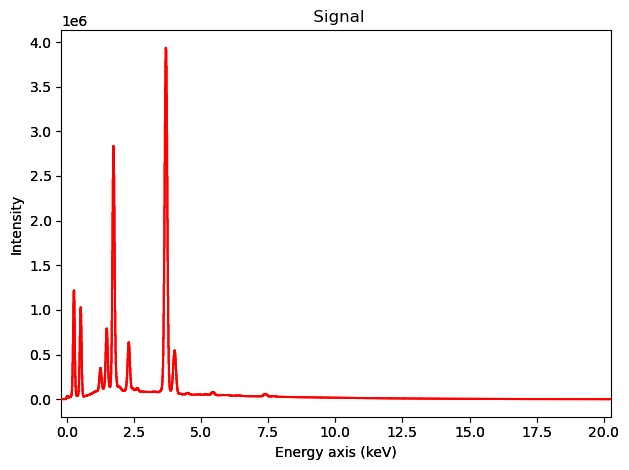

In [68]:
s_calib.sum(axis=(0,1)).plot(True)

In [69]:
s_norm, d_norm, d_vect = poisson_noise_norm(s_calib)

inital mean= 0.42442699273427326  inital max = 94  inital min= 0
(196608, 2048)
scaled mean= 3.097323096142709e-05  scaled max = 0.0331861655799986  scaled min= 0.0


/Users/robbinhilderman/opt/anaconda3/envs/hspy_environment/lib/python3.11/site-packages/hyperspy/signal.py:2451: UserWarning: Setting the `metadata` attribute is deprecated and will be removed in HyperSpy 2.0. Use the `set_item` and `add_dictionary` methods of the `metadata` attribute instead.
  warnings.warn(


In [ ]:
fig, axs = plt.subplots(1, 2, figsize = ((x/50)*2.5, y/50))

im1 = axs[0].imshow(s_calib.data.sum(axis=2), cmap = 'gray')
plt.colorbar(mappable = im1, ax = axs[0])
axs[0].set_title('Raw sum image')

im2 = axs[1].imshow(d_norm.sum(axis=2), cmap = 'gray')
plt.colorbar(mappable = im2, ax = axs[1])
axs[1].set_title('Poisson scaled sum image')

Text(0.5, 1.0, 'Poisson scaled sum image')

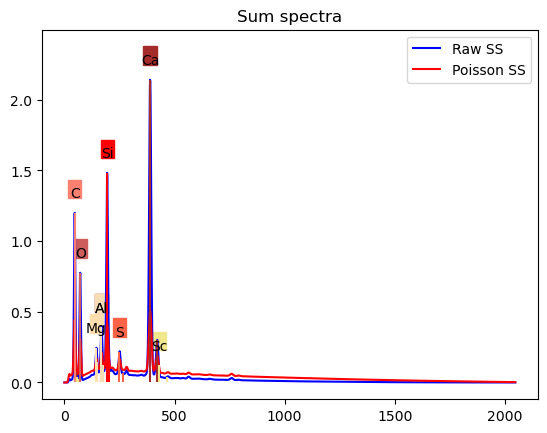

In [20]:
fig, ax = plt.subplots(1, 1)#, figsize = ((x/50)*2.5, y/50))

ax.plot(s_calib.data.sum(axis=(0,1))/s_calib.data.sum()*100, color = 'b', label = 'Raw SS')
ax.set_title('Sum spectra')

ax.plot(d_norm.sum(axis=(0,1))/d_norm.sum()*100, color = 'r', label = 'Poisson SS')

plt.legend()

add_xrl_labels(data_array = s_calib.data.sum(axis=(0,1))/s_calib.data.sum()*100, amplitude_thresh = 0.05, 
               ax = ax, elements_list = elements, colors_list = e_colors, scale = s_calib.axes_manager[2].scale, 
               offset = s_calib.axes_manager[2].offset)

In [71]:
os.chdir('/Volumes/Tobisha/W26/W26_M4')
#os.chdir('E:\W26\W26_T3')

In [22]:
np.save('poisson_vect.npy', d_vect)

# Mask Surface Defect

In [28]:
bse=io.imread('/Volumes/Tobisha/W26/W26_T6.1/W26_T6.1.tif')
print(bse.shape)

(1440, 1961)


In [26]:
bse_ds = ski.measure.block_reduce(bse, block_size = (2,2))

print(bse_ds.shape)
print(s_calib.data.shape)

(720, 981)
(719, 967, 2048)


In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(bse_ds, cmap = 'gray')
ax2.hist(bse_ds.reshape(bse_ds.shape[0]*bse_ds.shape[1]), bins = 2**8)
ax2.set_box_aspect(bse_ds.shape[0]/bse_ds.shape[1])
ax2.set_ylim((0, 8000))
ax2.set_xlim((0, 2**16))

In [ ]:
#thresh_value = ski.filters.threshold_otsu(bse_ds)
thresh_value =20000
print(thresh_value)

In [ ]:
mask = np.ones((384,512))

mask[bse_ds<=thresh_value] = 0

plt.figure()
plt.imshow(mask)

In [ ]:
np.save('mask.npy', mask)

In [56]:
mask.shape

(384, 512)

# Re-apply poissonian scaling

In [ ]:
s_calib.sum(axis=(0,1)).plot()

In [61]:
y, x, e= s_calib.data.shape
print(y,x,e)

384 512 2048


In [38]:
d_msk = flatten_masked_array(s_calib.data, mask)
d_im = reconstruct_masked_image(d_msk, mask, (y,x,e))
d_msk_norm = poisson_scale_mask(d_msk)

inital mean= 0.453448868463122  inital max = 94  inital min= 0
(166861, 2048)
scaled mean= 3.369737071957267e-05  scaled max = 0.0331861655799986  scaled min= 0.0


In [ ]:
plt.plot(d_msk.sum(0), color = 'r', label = 'Poisson of mask')

In [ ]:
#%matplotlib qt5
plt.figure()
plt.imshow(bse_ds, cmap = 'gray')
plt.pcolormesh(d_im.sum(axis=2), cmap = 'gray')
plt.gca().set_box_aspect(384/512)
#plt.gca().invert_yaxis()

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(d_msk_norm.sum(0), color = 'r', label = 'Poisson of mask')
plt.plot(d_norm.sum((0,1)), color = 'black', linestyle = 'dashed', label = 'Poisson of raw')

plt.legend()

In [39]:
# save masked poisson scaled data
np.save('poisson_vect_pore_mask_.npy', d_msk_norm)
d_msk_norm.shape

(166861, 2048)

# Dimentional Reduction

In [15]:
os.chdir('/Volumes/Tobisha/W26/W26_T4/NMF')

In [16]:
y, x, e= s_calib.data.shape
print(y,x,e)

384 512 2048


NMF

In [17]:
fornmf = d_msk_norm
#data_sc = skl.preprocessing.scale(fornmf, axis = 1)

nmf = NMF(n_components=6) 
nmf.fit(fornmf)

f=plt.figure(figsize=(7,5)) 
#plt.plot(np.cumsum(nmf.explained_variance_ratio_)) 
#plt.xlabel('number of components') 
#plt.ylabel('cumulative explained variance')
compz = nmf.transform(fornmf) 

C:\Users\Dragonfly\anaconda3\envs\hyperspy\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


<Figure size 700x500 with 0 Axes>

In [18]:
compz_im = reconstruct_masked_image(compz, mask, (y, x, 6))

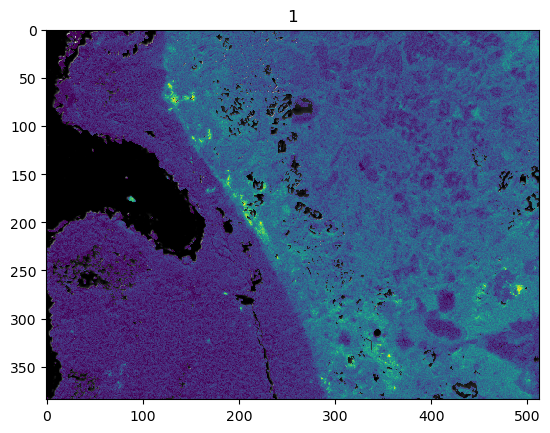

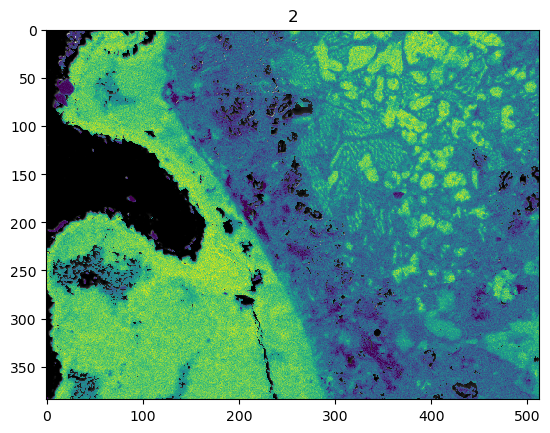

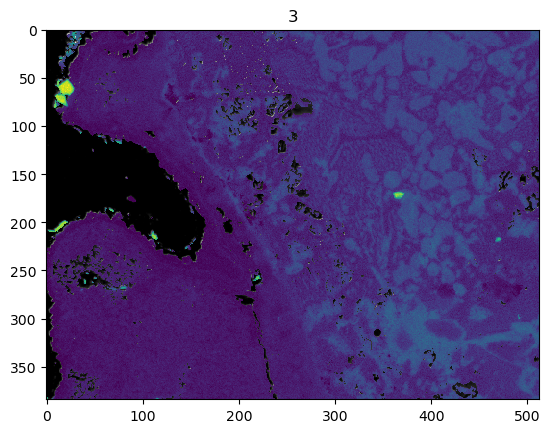

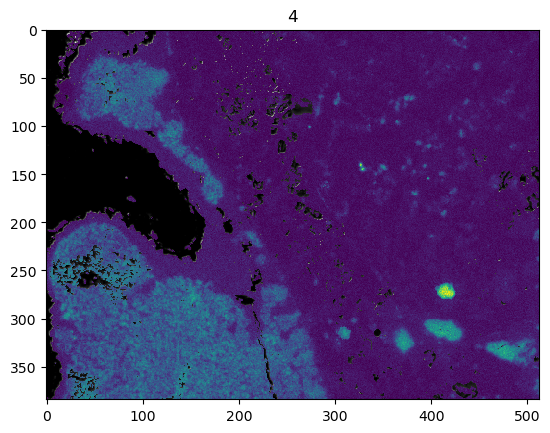

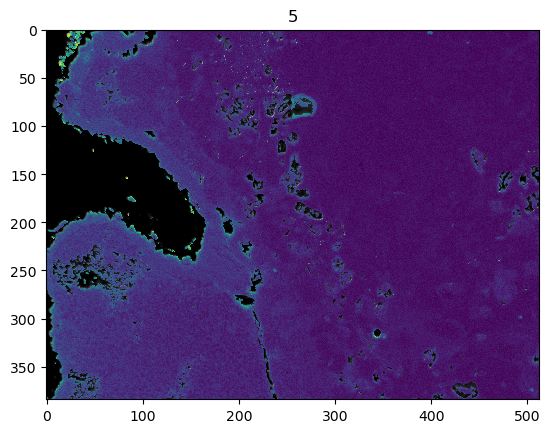

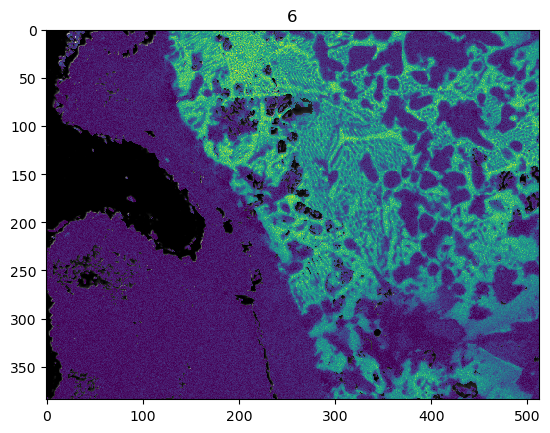

In [19]:
%matplotlib inline
for i in range(0,6):
    plt.figure()
    plt.title(i+1)
    plt.imshow(bse_ds, cmap = 'gray')           
    plt.pcolormesh(compz_im[:,:,i])

In [20]:
nmf_loads = nmf.components_

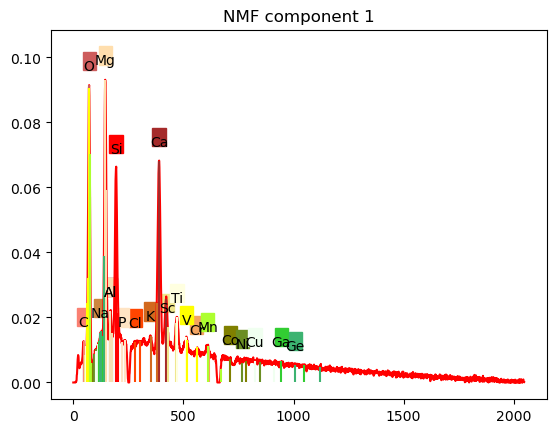

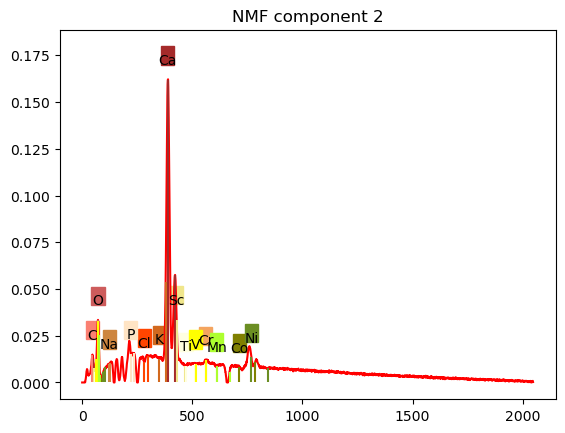

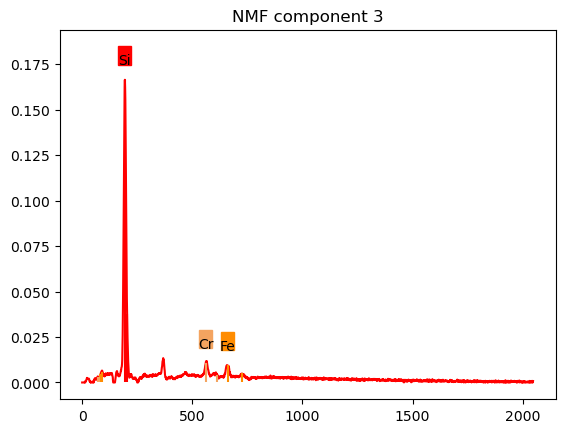

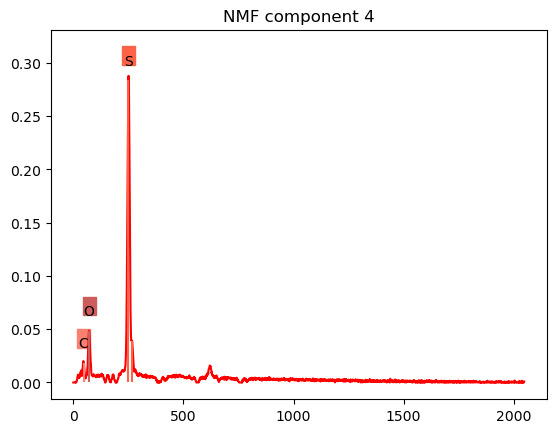

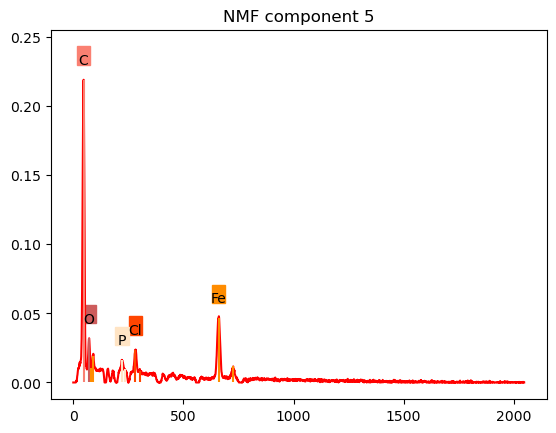

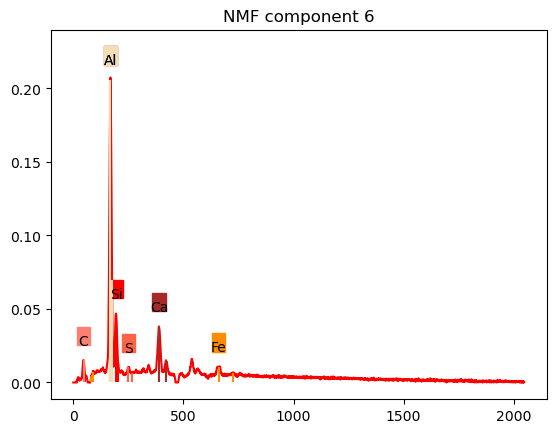

In [21]:
scale = s_calib.axes_manager[2].scale
offset = s_calib.axes_manager[2].offset

fac = 1
for l in nmf_loads:
    plt.figure()
    plt.plot(l, c = 'r')
    plt.title(f'NMF component {fac}')
    
    x_tck_labels = np.arange(0,11,1)
    x_tck = x_tck_labels*scale - (offset/scale)
    
#     plt.xticks(x_tck)
#     plt.(x_tck_labels)
    
    add_xrl_labels(data_array = l, amplitude_thresh = 0.05, 
               ax = plt.gca(), elements_list = elements, colors_list = e_colors, scale = s_calib.axes_manager[2].scale, 
               offset = s_calib.axes_manager[2].offset)
    
    #add_xrl_labels(data_array = l, amplitude_thresh = 0.01, ax = plt.gca(), elements_list1 = elements_ka, 
                #elements_list2 = elements_REE_PGM, scale =s_calib.axes_manager[2].scale, 
                #offset = s_calib.axes_manager[2].offset)
    fac+=1

In [330]:
np.save('/Volumes/Tobisha/W24/W24_T3M2/NMF/NMF5', arr = NMF, allow_pickle= True)

In [17]:
NMF = np.load('/Volumes/Tobisha/W26/W26_T6.2M3/NMF/NMF7.npy', allow_pickle= True)

# BIC test

Load DR

In [18]:
NMF = np.load('/Volumes/Tobisha/W26/W26_T3/NMF/NMF.npy', allow_pickle= True)

In [31]:
%matplotlib qt5

# Assuming you have data loaded in a pandas DataFrame called 'compz'

# Compute Elbow and BIC values
results = compute_elbow_bic(compz, max_clusters=10, use_gmm=False)

# Find the elbow point
optimal_k = find_elbow(results['distortions'])

# Plot the Elbow and BIC methods separately
plot_elbow(results['ks'], results['distortions'])
plot_bic(results['ks'], results['bics'])

# Plot both the Elbow and BIC methods together using Seaborn
plot_elbow_bic_seaborn(results['ks'], results['distortions'], results['bics'], optimal_k, title='Elbow and BIC Analysis')

C:\Users\Dragonfly\anaconda3\envs\hyperspy\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Dragonfly\anaconda3\envs\hyperspy\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Dragonfly\anaconda3\envs\hyperspy\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Dragonfly\anaconda3\envs\hyperspy\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

In [30]:
#ks, distortions, bics, optimal_k = ... # These values should be obtained from previous computations
plot_elbow_bic_seaborn(ks, distortions, bics, optimal_k)

NameError: name 'ks' is not defined

# Clustering

HDBSCAN

In [331]:
labels = ('/Volumes/Tobisha/W24/W24_T3M2/NMF5.npy')

In [17]:
labels = np.load('/Volumes/Tobisha/W26/W26_T3/NMF/NMF.npy',allow_pickle= True)

In [137]:
clust = hdbscan.HDBSCAN(min_cluster_size=100,min_samples=170,prediction_data=True) 
clust.fit(compz)

labels = clust.labels_
print(labels.shape)
# Hard cluster label for each data point, including outlier cluster of '-1'

n_cluster = len(set(labels))
print('Number of clusters:',str(n_cluster))
# Total number of clusters, inclusive of 'outliers' cluster

labels[np.where(labels==-1)[0]]= n_cluster-1 
# Assign the largest cluster number as outlier cluster

(111506,)
Number of clusters: 9


In [35]:
# calculate % of cluster 4 assigned as outliers
n_outliers = 0
for i in range(0,int(compz.shape[0])):
    if labels[i]==n_cluster-1:
        n_outliers+=1
print('Percent outliers: '+str((n_outliers/compz.shape[0])*100))

Percent outliers: 39.06336878732983


(9, 384, 512)


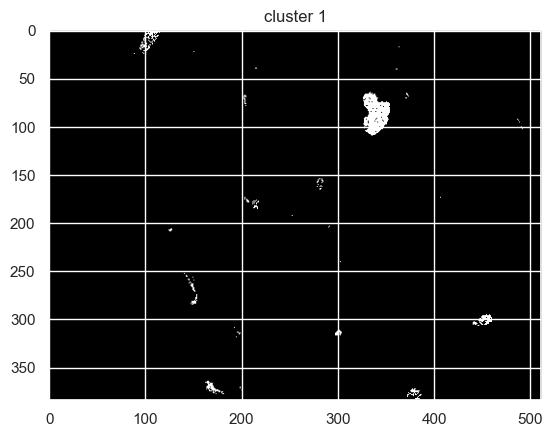

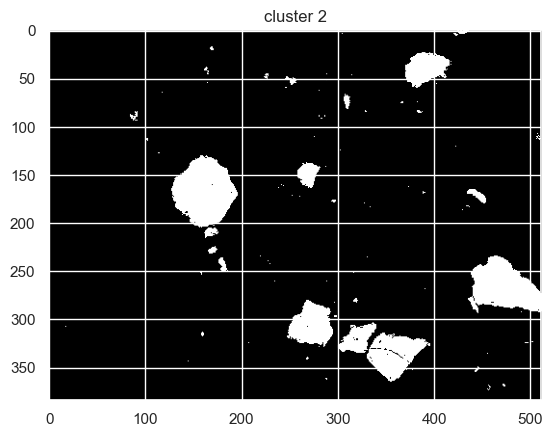

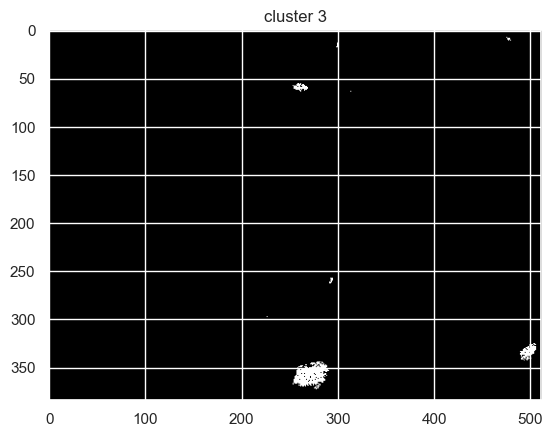

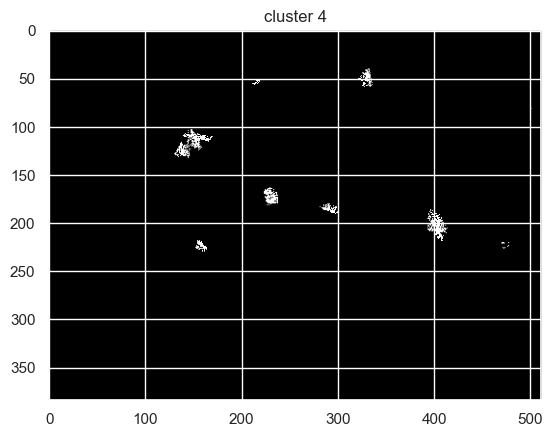

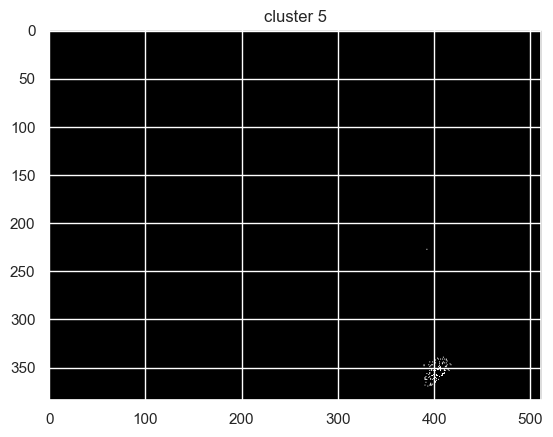

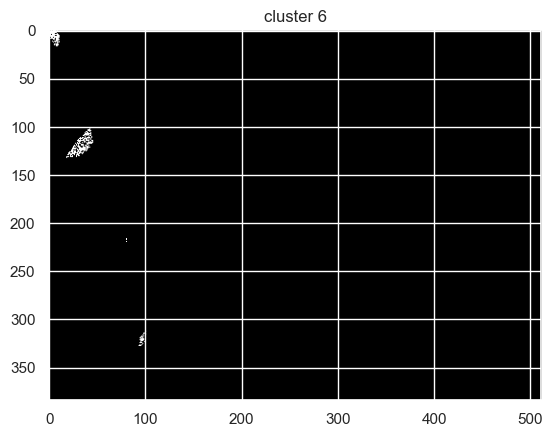

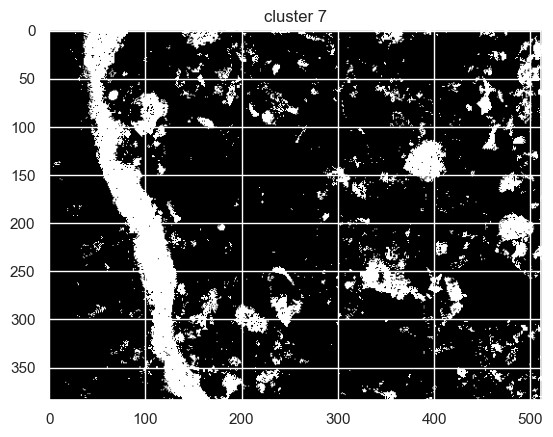

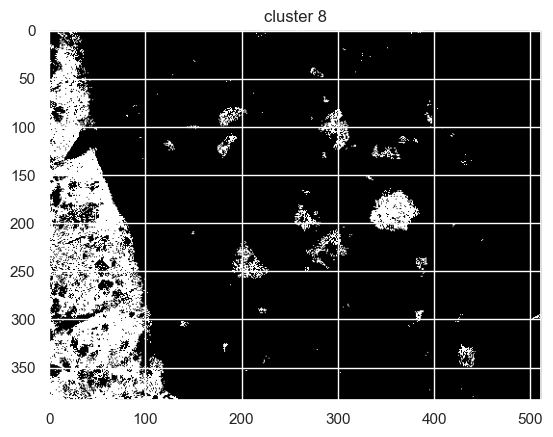

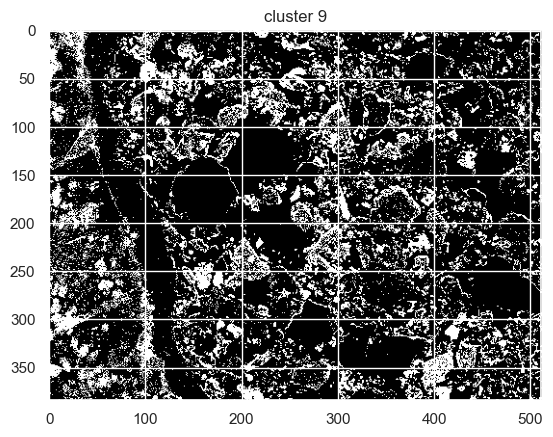

In [138]:
#New way/Faisal's
# reconstruct hard cluster assignments
label_map = reconstruct_masked_image(arr = labels, mask = mask, im_shape = (y, x))
# create binary segmentations per cluster
labels_seg = []
labels_spec = []

for i in range(0, n_cluster):
    
    labels_seg.append(np.zeros((y, x)))
    labels_seg[i][label_map==i] = 1
    #labels_spec.append(s_calib.data[label_im==i, :].sum(axis= (0)))
    
    plt.figure()
    #plt.imshow(bse_ds, cmap='binary_r')
    plt.imshow(labels_seg[i],cmap='binary_r')
    plt.title(f'cluster {i+1}')
    
labels_seg = np.asarray(labels_seg)
print(labels_seg.shape)

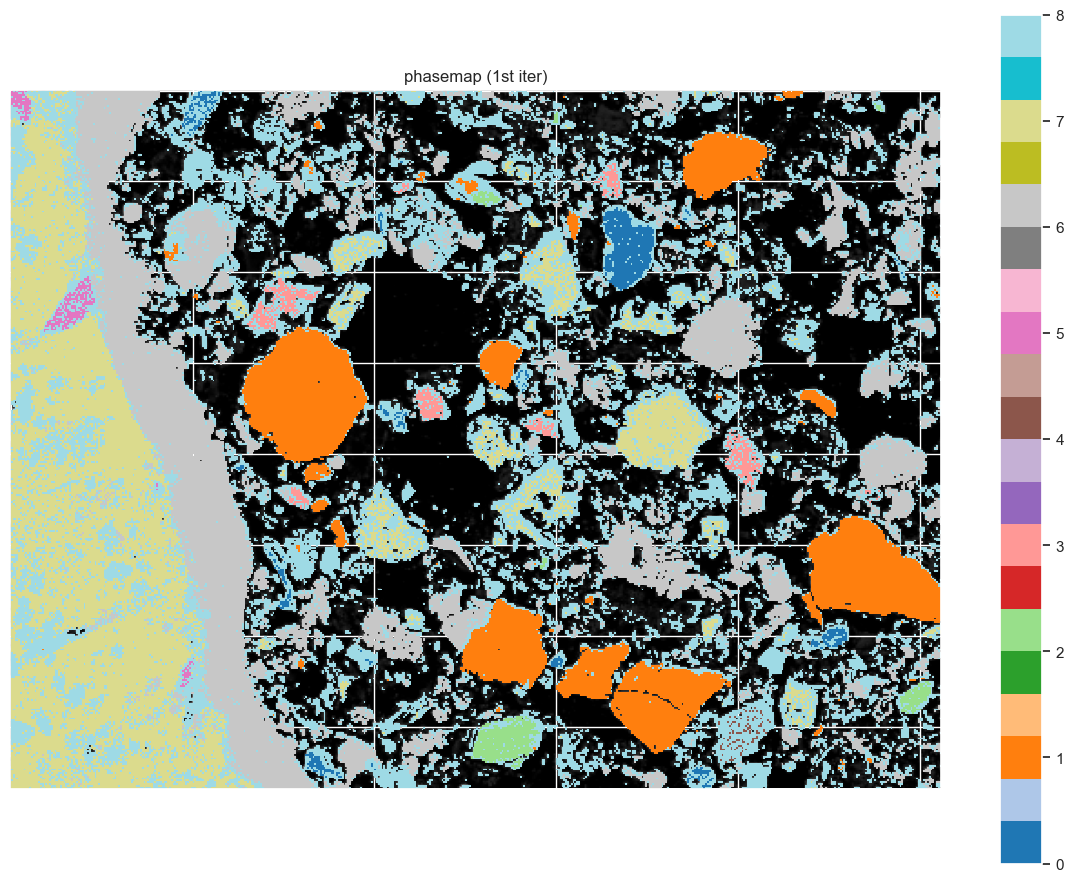

In [139]:
plt_phasemap(label_map, bse_im = bse_ds, scale = s_calib.axes_manager[0].scale, mpl_cmap = 'tab20',
             phasemap_title = 'phasemap (1st iter)')
#plt.savefig(f'phasemap (1st iter)')

In [43]:
np.save('/Volumes/Tobisha/W26/W26_T6.2M3/NMF/NMF7_HDBSCAN_100-170', arr = labels_seg, allow_pickle= True)

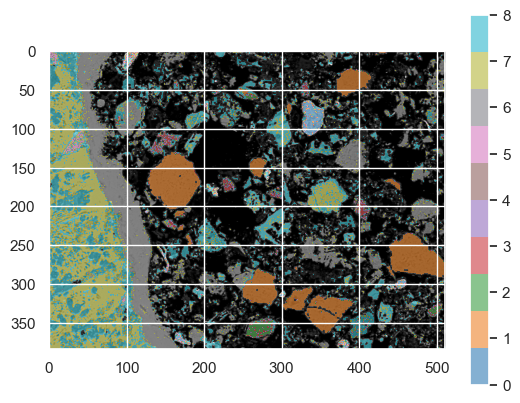

In [140]:
plt.figure()
plt.imshow(bse_ds, cmap = 'gray')
plt.imshow(label_map, cmap='tab10', alpha=0.5)
plt.colorbar()
#plt.savefig(f'phasemap_bse(1st iter)')

In [ ]:
%matplotlib inline
plt.figure()
clust.condensed_tree_.plot(cmap='viridis', select_clusters=True, label_clusters = True, 
                           selection_palette=sns.color_palette('Accent', n_cluster))

# Save spectra for back projection

In [383]:
np.save('/Volumes/Tobisha/W24/W24_T3M2/NMF/NMF3_HDBSCAN_250-220', arr = labels)

In [141]:
# create summed spectra as % of total counts per cluster
clus_spec = []

for i in range(0,n_cluster):    
    clus_spec.append((s_calib.data[labels_seg[i]==1,:]).sum(axis=0))

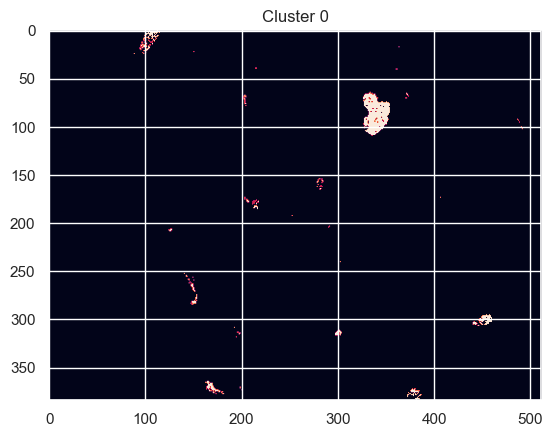

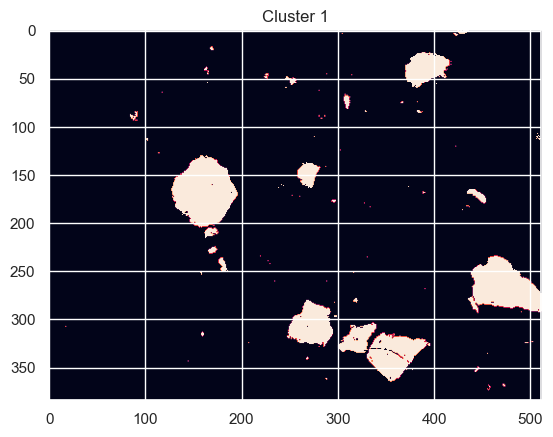

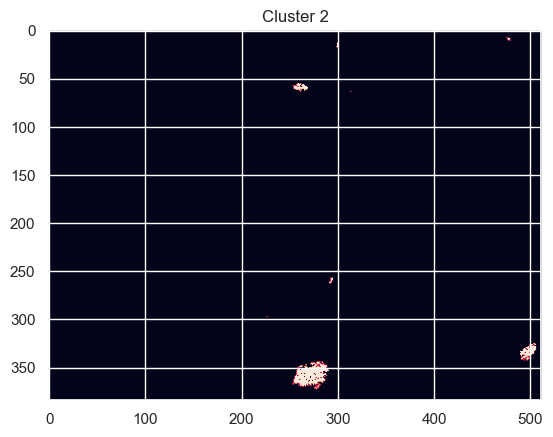

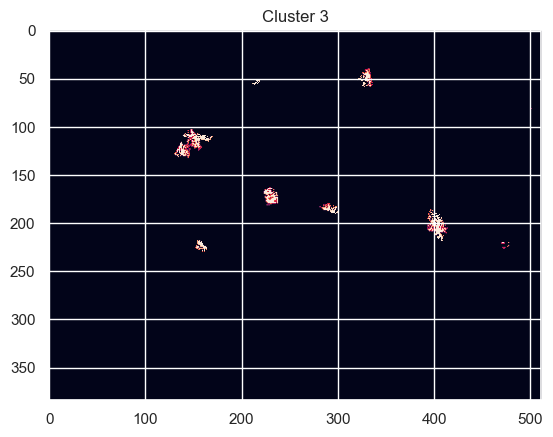

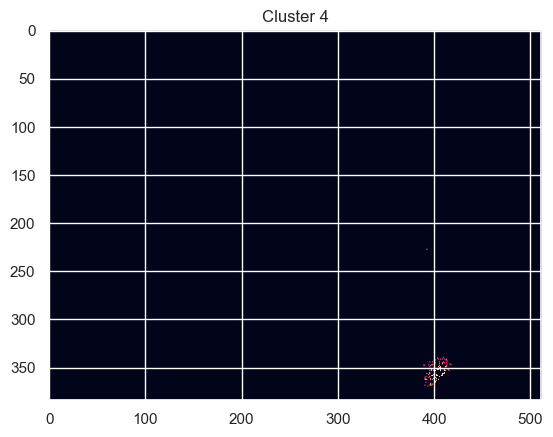

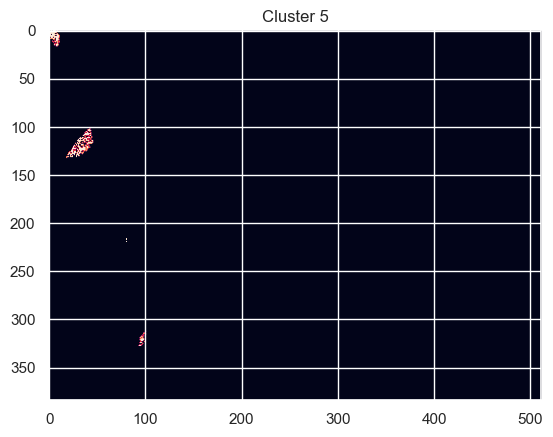

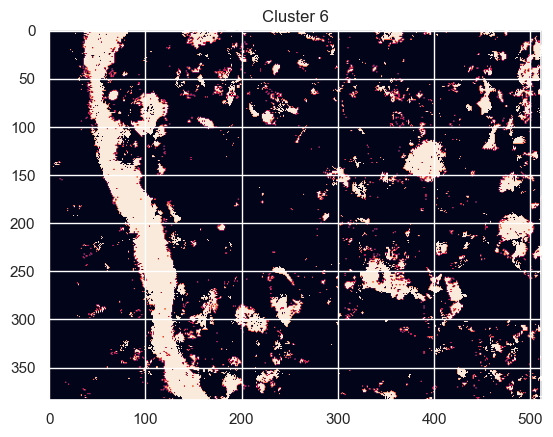

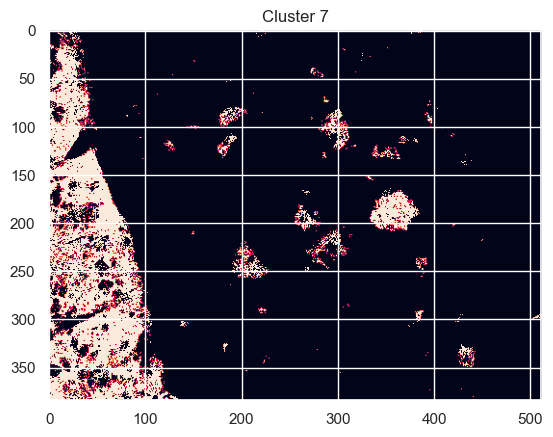

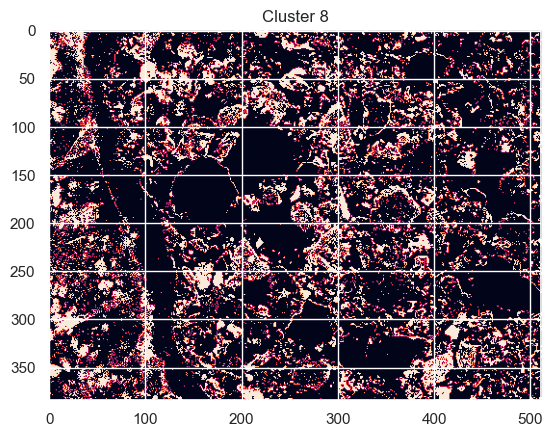

In [142]:
%matplotlib inline

c_idx = 0
for spec in clus_spec:
    plt.figure()
    plt.imshow(labels_seg[c_idx])
    plt.title(f'Cluster {c_idx}')
    c_idx+=1
    #plt.savefig(f'Cluster {c_idx} Image')

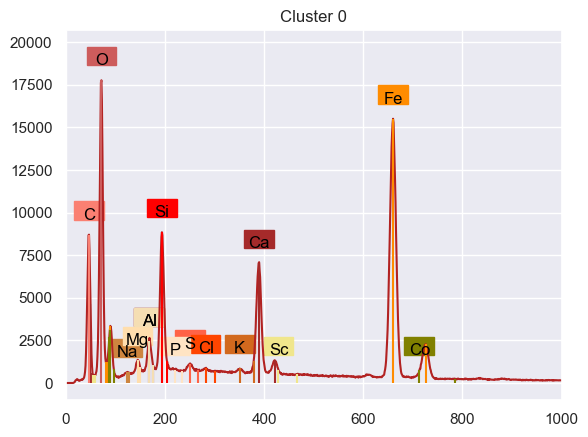

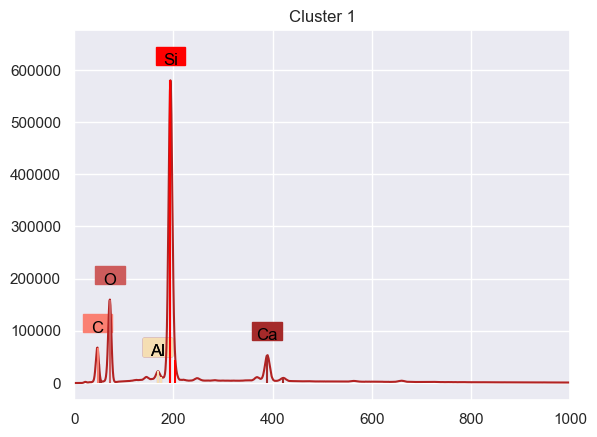

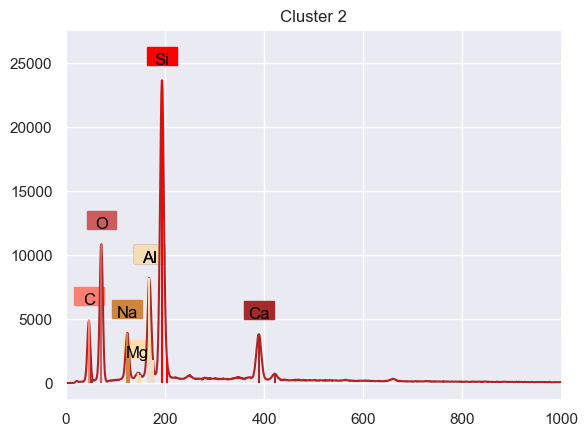

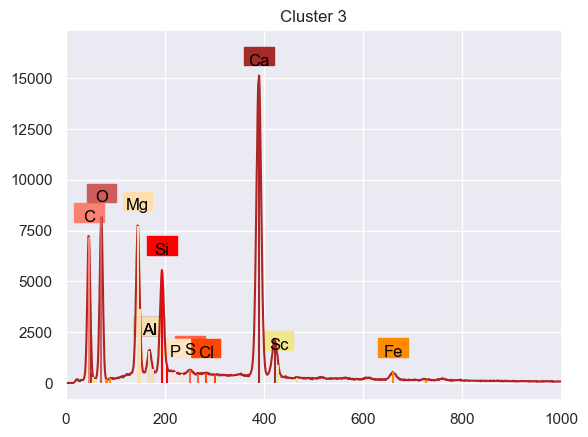

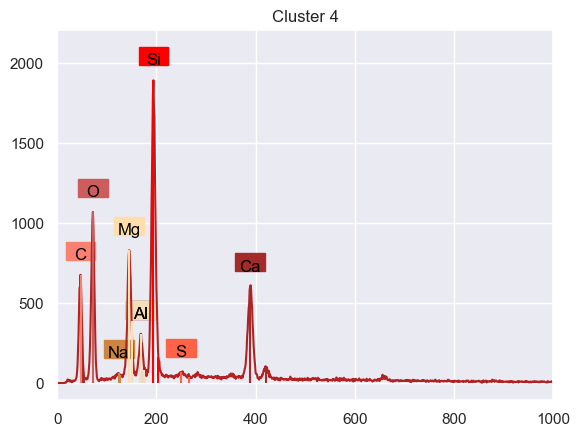

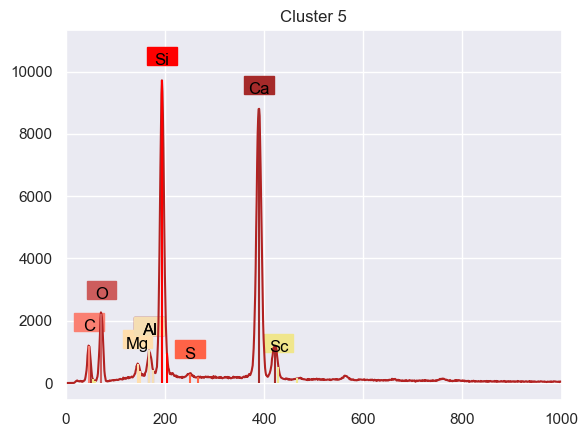

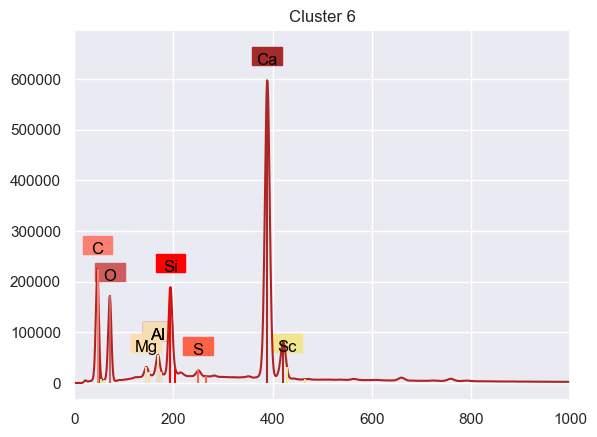

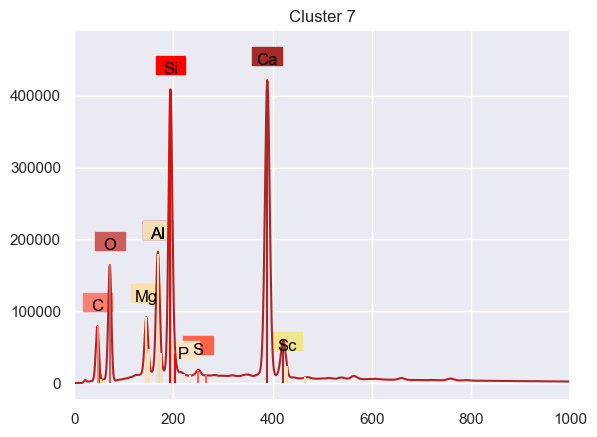

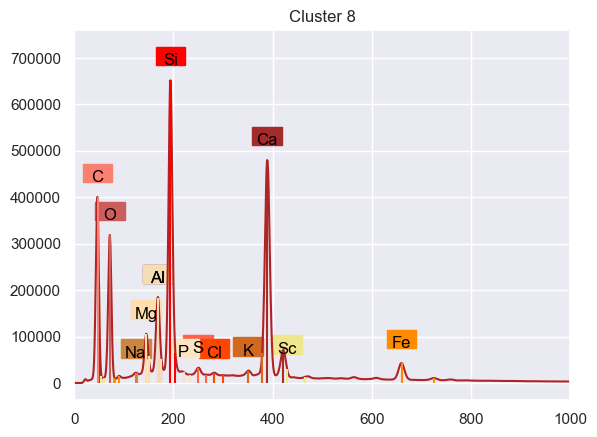

In [143]:
%matplotlib inline

c_idx = 0
for spec in clus_spec:
    plt.figure()
    plt.plot(spec, c = 'firebrick')
    plt.xlim(right=1000)
    plt.xlim(left=0) 
    plt.title(f'Cluster {c_idx}')
    
    
    #add_xrl_labels(data_array =spec, amplitude_thresh = 0.01, ax = plt.gca(), 
                   #elements_list1 = elements_ka, elements_list2 = elements_REE_PGM, 
                   #scale = s_calib.axes_manager[2].scale, offset = 
                   #s_calib.axes_manager[2].offset)
    
    
    add_xrl_labels(data_array = spec, amplitude_thresh = 0.03, 
            ax = plt.gca(), elements_list = elements, colors_list = e_colors, scale = s_calib.axes_manager[2].scale, 
            offset = s_calib.axes_manager[2].offset)
    
    #plt.savefig(f'Cluster {c_idx}')
    c_idx+=1

# Conversion from .msa to .spx file and exporting to Bruker Espirit format

In [387]:
os.chdir('/Volumes/Tobisha/W24/W24_T3M2/NMF/NMF3_HDBSCAN_250-220/MSA_SPX')

In [388]:
for i in range(0, n_cluster):
 
    COI = flatten_masked_array(s_calib.data, labels_seg[i])
    clus_spec = hs.signals.Signal1D(COI.sum(0))
    clus_spec.set_signal_type("EDS_SEM")
    clus_spec.change_dtype('float32')
    clus_spec.axes_manager[0].name = 'E'
    clus_spec.axes_manager[0].offset = s_calib.axes_manager['Energy'].offset
    clus_spec.axes_manager[0].scale = s_calib.axes_manager['Energy'].scale
    clus_spec.axes_manager[0].units = s_calib.axes_manager['Energy'].units
    to_spx(clus_spec, f_name= f'Cluster{i+1}')
    clus_spec.save(f'W24_T3M3_NMF5_cluster{i+1}', extension='msa', format='XY')
    

In [389]:
Offset = clus_spec.axes_manager[0].offset
Scale = clus_spec.axes_manager[0].scale
Offset, Scale

(-0.19739659118652345, 0.00999934196472168)

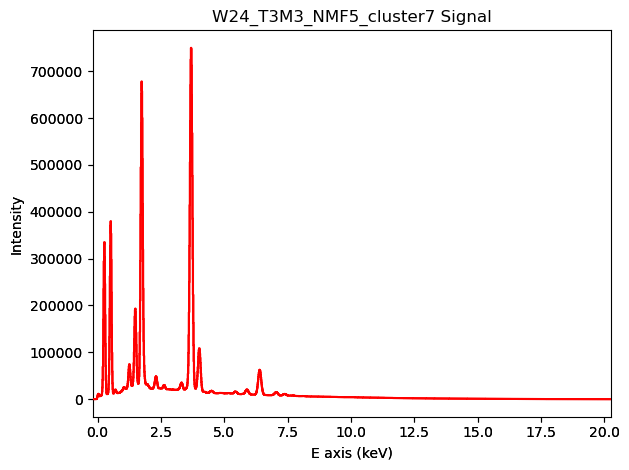

In [390]:
clus_spec.plot(True)

# Calculate Pixels per Cluster

In [63]:
labels_seg.data.shape

(9, 384, 512)

In [61]:
y, x, e = labels_seg.data.shape

In [70]:
y, x, e

(9, 384, 512)

In [66]:
counts = labels_seg.data(axis = (0,1,2))
print(f'total map counts: {counts}')
#cpp = counts/(y*x)
#print(f'counts per pixel: {cpp}')

TypeError: 'memoryview' object is not callable

In [92]:
c_idx = 0
for i in range(0, n_cluster):
    np.count_nonzero(labels_seg.data == i)
    c_idx+=1

In [77]:
np.count_nonzero(labels_seg.data)

111506

In [93]:
np.count_nonzero(labels_seg.data== 1)

0

In [78]:
np.count_nonzero(labels_seg.data == c_idx[1])

TypeError: 'int' object is not subscriptable

In [145]:
for i in range(0, n_cluster):
    binary = labels_seg[i]==[1,:]

SyntaxError: invalid syntax (3468330957.py, line 2)

In [151]:
binary = labels_seg == 3 # where i is the cluster index of interest

In [152]:
np.sum(binary)

0